# **Air Pollution Complaints in Chicago, CY2010**
---
## Setup

In [1]:
# Dependencies and setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.patches as mpatches
import requests
import json
import gmaps
import os
import time

# Import API key
from config import gkey

## **Question 1: Which Chicago neighborhoods submitted the highest number of air pollution complaints in 2010?**
-----

### Bar Chart of Air Pollution Complaints by Region

In [2]:
# import merged dataset
path = "Resources/merged_data.csv"
pollution_df = pd.read_csv(path)

# set up the larger regions based on https://commons.wikimedia.org/wiki/File:Chicago_neighborhoods_map.png
far_north = ["Edison Park", "Norwood Park", "Jefferson Park",
            "Forest Glen", "North Park", "Albany Park", "West Ridge", 
            "Lincoln Square", "Rogers Park", "Edgewater", "Uptown"]
northwest = ["Dunning", "Portage Park", "Montclare", "Belmont Cragin",
            "Hermosa", "Irving Park"]
north = ["Avondale", "North Center", "Lake View", "Lincoln Park", "Logan Square"]
central = ["Near North Side", "Loop", "Near South Side"]
west = ["Austin", "Humboldt Park", "West Town", "West Garfield Park",
        "East Garfield Park", "Near West Side", "Lower West Side", 
        "North Lawndale", "South Lawndale"]
southwest = ["Garfield Ridge", "Clearing", "Archer Heights", "West Elsdon"
            "Brighton Park", "Gage Park", "McKinley Park", "New City",
            "West Lawn", "Chicago Lawn", "West Englewood", "Englewood", "Brighton Park"]
south = ["Bridgeport", "Armor Square", "Douglas", "Fuller Park", "Grand Boulevard",
        "Oakland", "Kenwood", "Washington Park", "Hyde Park", "Woodlawn",
        "Greater Grand Crossing", "South Shore"]
far_southwest = ["Ashburn", "Auburn Gresham", "Washington Heights",
                "Beverly", "Mount Greenman", "Morgan Park", "Mount Greenwood"]
far_southeast = ["Chatham", "Avalon Park", "South Chicago", "Calumet Heights",
                "Burnside", "Roseland", "West Pullman", "Riverdale", "Hegewisch",
                "South Deering", "East Side", "Pullman"]

In [3]:
# create new df with region info for each complaint added
regions_df = pollution_df
regions_df["Region"] = ""
for index, neighborhood in enumerate(pollution_df["Neighborhood"]):
    if neighborhood in far_north:
        regions_df.loc[index, "Region"] = "Far North"
    elif neighborhood in northwest:
        regions_df.loc[index, "Region"] = "Northwest"
    elif neighborhood in north:
        regions_df.loc[index, "Region"] = "North"
    elif neighborhood in central:
        regions_df.loc[index, "Region"] = "Central"
    elif neighborhood in west:
        regions_df.loc[index, "Region"] = "West"
    elif neighborhood in southwest:
        regions_df.loc[index, "Region"] = "Southwest"
    elif neighborhood in south:
        regions_df.loc[index, "Region"] = "South"
    elif neighborhood in far_southwest:
        regions_df.loc[index, "Region"] = "Far Southwest"
    elif neighborhood in far_southeast:
        regions_df.loc[index, "Region"] = "Far Southeast"
regions_df

,Unnamed: 0,COMPLAINT ID,COMPLAINT TYPE,ADDRESS,Neighborhood,STREET NUMBER FROM,STREET NUMBER TO,DIRECTION,STREET NAME,STREET TYPE,...,LOCATION,Community Area Number,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Region
0,0,DOECOMP29999,Air Pollution Work Order,"700 E 107TH ST, CHICAGO, IL",Pullman,700,NaN,E,107TH,ST,...,NaN,50.0,1.5,21.6,22.8,13.1,38.6,20588,51.0,Far Southeast
1,1,DOECOMP29998,Air Pollution Work Order,"700 E 107TH ST, CHICAGO, IL",Pullman,700,NaN,E,107TH,ST,...,NaN,50.0,1.5,21.6,22.8,13.1,38.6,20588,51.0,Far Southeast
2,2,DOECOMP30000,Air Pollution Work Order,"700 E 107TH ST, CHICAGO, IL",Pullman,700,NaN,E,107TH,ST,...,NaN,50.0,1.5,21.6,22.8,13.1,38.6,20588,51.0,Far Southeast
3,3,DOECOMP1839,Air Pollution Work Order,"11436 S FORRESTVILLE AVE, CHICAGO, IL",Pullman,11436,NaN,S,FORRESTVILLE,AVE,...,NaN,50.0,1.5,21.6,22.8,13.1,38.6,20588,51.0,Far Southeast
4,4,DOECOMP8772,Air Pollution Work Order,"2019 W 111TH ST, CHICAGO, IL",Morgan Park,2019,NaN,W,111TH,ST,...,NaN,75.0,0.8,13.2,15.0,10.8,40.3,27149,30.0,Far Southwest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,243,DOECOMP31879,Air Pollution Work Order,"7600 S SEELEY AVE, CHICAGO, IL",Auburn Gresham,7600,NaN,S,SEELEY,AVE,...,NaN,71.0,4.0,27.6,28.3,18.5,41.9,15528,74.0,Far Southwest
244,244,DOECOMP32306,Air Pollution Work Order,"7901 S WENTWORTH AVE, CHICAGO, IL",Auburn Gresham,7901,NaN,S,WENTWORTH,AVE,...,NaN,71.0,4.0,27.6,28.3,18.5,41.9,15528,74.0,Far Southwest
245,245,DOECOMP32307,Air Pollution Work Order,"7901 S WENTWORTH AVE, CHICAGO, IL",Auburn Gresham,7901,NaN,S,WENTWORTH,AVE,...,NaN,71.0,4.0,27.6,28.3,18.5,41.9,15528,74.0,Far Southwest
246,246,DOECOMP35677,Air Pollution Work Order,"13000 S TORRENCE AVE, CHICAGO, IL",South Deering,13000,NaN,S,TORRENCE,AVE,...,NaN,51.0,4.0,29.2,16.3,21.0,39.5,14685,65.0,Far Southeast


In [4]:
# create new groupby to see number of complaints per region
grouped_region = regions_df.groupby(by="Region")
grouped_region_complaint = pd.DataFrame()
grouped_region_complaint["Complaint Count"] = grouped_region["COMPLAINT TYPE"].count()
grouped_region_complaint.reset_index(inplace=True)

# x and y values for graph
regions = grouped_region_complaint["Region"]
complaint_num = grouped_region_complaint["Complaint Count"]
ticks = [value for value in regions]

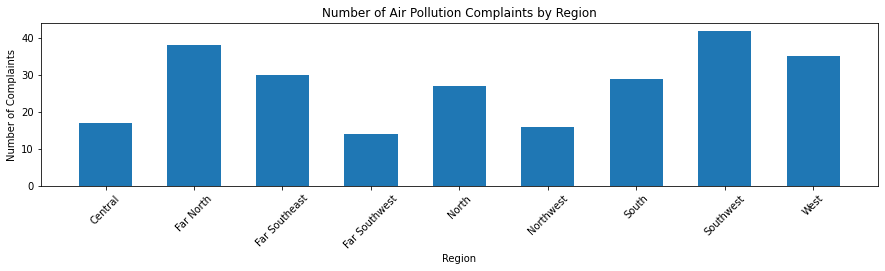

In [5]:
# create bar graph
plt.figure(figsize=(15, 3))

figure = plt.bar(regions, complaint_num, align='center', width=0.6)
# formatting
plt.xticks(ticks, regions, rotation=45)
plt.xlabel("Region")
plt.ylabel("Number of Complaints")
plt.title("Number of Air Pollution Complaints by Region")
plt.savefig("Output/Q1_Boxplot_Regions.png")
plt.show()

### Bar Chart of Air Pollution Complaints by Neighborhood

In [6]:
# group by neighborhood and find the frequency of complaints per neighborhood
grouped_df = pollution_df.groupby(by="Neighborhood")
# finds the number of complaints and avg income per neighborhood
grouped_complaint = pd.DataFrame()
grouped_complaint["Complaint frequency"] = grouped_df["COMPLAINT TYPE"].count()
grouped_complaint["Avg Per Capita Income"] = grouped_df["PER CAPITA INCOME "].mean()
grouped_complaint.head()
# Bar - neighborhoods / # complaints (color bars by region)
grouped_df = grouped_complaint.reset_index()
# retrieve columns of data to be used in bar chart
neighborhoods = grouped_df["Neighborhood"]
complaints = grouped_df["Complaint frequency"]
tick_locations = [value for value in neighborhoods]

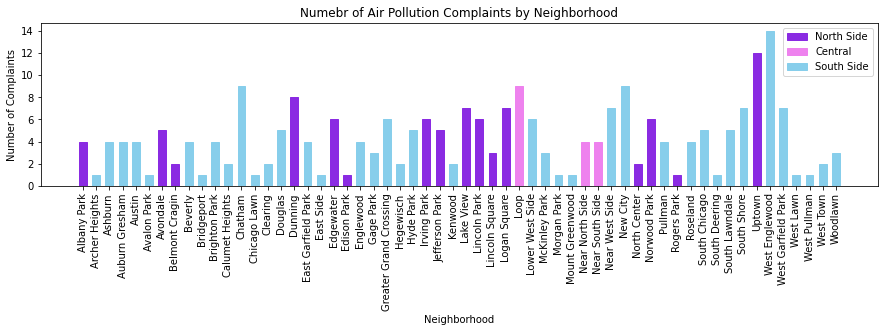

In [7]:
plt.figure(figsize=(15, 3)) # width 20, height 3
# create bar graph
figure = plt.bar(neighborhoods, complaints, align='center', width=0.6)
plt.xticks(tick_locations, neighborhoods, rotation=90)
# color code based on larger region
for index, area in enumerate(neighborhoods):
    if area in far_north:
        figure[index].set_color('blueviolet')
    if area in northwest:
        figure[index].set_color('blueviolet')
    if area in north:
        figure[index].set_color('blueviolet')        
    if area in central:
        figure[index].set_color('violet')
    if area in west:
        figure[index].set_color('skyblue')
    if area in southwest:
        figure[index].set_color('skyblue')
    if area in south:
        figure[index].set_color('skyblue')
    if area in far_southwest:
        figure[index].set_color('skyblue')
    if area in far_southeast:
        figure[index].set_color('skyblue')
# formatting
plt.ylabel("Number of Complaints")
plt.xlabel("Neighborhood")
plt.title("Numebr of Air Pollution Complaints by Neighborhood")
# legend info
purple = mpatches.Patch(color='blueviolet', label='North Side')
teal = mpatches.Patch(color="skyblue", label="South Side")
pink = mpatches.Patch(color="violet", label="Central")
plt.legend(handles=[purple, pink, teal])
plt.savefig("Output/Q1_Boxplot_Neighborhood.png")
plt.show()

### Heat Map of Air Pollution Complaints by Neighborhood

In [8]:
# Load merged dataset into Jupyter Notebook
merged_dataset = "Resources/merged_data.csv"
air_pollution_df = pd.read_csv(merged_dataset)
# Create dataframe showing number of complaints by neighborhood in descending order 
neighborhood = air_pollution_df.groupby(["Neighborhood"])
complaint_count = neighborhood["COMPLAINT ID"].count()
neighborhood_df = pd.DataFrame({"Number of Complaints": complaint_count})
neighborhood_df = neighborhood_df.sort_values(["Number of Complaints"], ascending = False).reset_index()
# Add columns to neighborhood_df for location data
neighborhood_df["Region"] = neighborhood_df["Neighborhood"].astype(str) + ", Chicago, IL"
neighborhood_df["Latitude"] = ""
neighborhood_df["Longitude"] = ""
# Print dataframe header for reference
neighborhood_df.head()

,Neighborhood,Number of Complaints,Region,Latitude,Longitude
0,West Englewood,14,"West Englewood, Chicago, IL",,
1,Uptown,12,"Uptown, Chicago, IL",,
2,New City,9,"New City, Chicago, IL",,
3,Chatham,9,"Chatham, Chicago, IL",,
4,Loop,9,"Loop, Chicago, IL",,


In [9]:
print("---------------------------")
print("Beginning data retrieval...")
print("---------------------------")
# Build partial query URL
base_url = "https://maps.googleapis.com/maps/api/geocode/json"
params = {"key" : gkey}
# Iterate through rows of neighborhood_df 
for index, row in neighborhood_df.iterrows():
    # Get address from neighborhood_df
    search_address = row["Region"]
    # Add keyword to params dictionary
    params["address"] = search_address
    # Assemble URL and make API request
    print(f"Retrieving Results for Index {index}: {search_address}.")
    response = requests.get(base_url, params = params).json()
    # Extract location coordinates and save to neighborhood_df
    neighborhood_data = response
    try:
        neighborhood_df.loc[index, "Latitude"] = neighborhood_data["results"][0]["geometry"]["location"]["lat"]
        neighborhood_df.loc[index, "Longitude"] = neighborhood_data["results"][0]["geometry"]["location"]["lng"]
    # Skip row if neighborhood not found
    except (KeyError, IndexError):
        print("Neighborhood not found. Skipping...")
    print("-------------")
    # Set 5s timer for API requests
    time.sleep(5)
print("---------------------------")
print("Data retrieval complete.")
print("---------------------------")

---------------------------
Beginning data retrieval...
---------------------------
Retrieving Results for Index 0: West Englewood, Chicago, IL.
-------------
Retrieving Results for Index 1: Uptown, Chicago, IL.
-------------
Retrieving Results for Index 2: New City, Chicago, IL.
-------------
Retrieving Results for Index 3: Chatham, Chicago, IL.
-------------
Retrieving Results for Index 4: Loop, Chicago, IL.
-------------
Retrieving Results for Index 5: Dunning, Chicago, IL.
-------------
Retrieving Results for Index 6: Logan Square, Chicago, IL.
-------------
Retrieving Results for Index 7: Near West Side, Chicago, IL.
-------------
Retrieving Results for Index 8: Lake View, Chicago, IL.
-------------
Retrieving Results for Index 9: South Shore, Chicago, IL.
-------------
Retrieving Results for Index 10: West Garfield Park, Chicago, IL.
-------------
Retrieving Results for Index 11: Irving Park, Chicago, IL.
-------------
Retrieving Results for Index 12: Greater Grand Crossing, Chic

In [10]:
# Print neighborhood_df to ensure location data has updated
neighborhood_df

,Neighborhood,Number of Complaints,Region,Latitude,Longitude
0,West Englewood,14,"West Englewood, Chicago, IL",41.779516,-87.664291
1,Uptown,12,"Uptown, Chicago, IL",41.96654,-87.65334
2,New City,9,"New City, Chicago, IL",41.806677,-87.667976
3,Chatham,9,"Chatham, Chicago, IL",41.74012,-87.614636
4,Loop,9,"Loop, Chicago, IL",41.878635,-87.625055
5,Dunning,8,"Dunning, Chicago, IL",41.94526,-87.807
6,Logan Square,7,"Logan Square, Chicago, IL",41.92306,-87.709291
7,Near West Side,7,"Near West Side, Chicago, IL",41.866846,-87.666409
8,Lake View,7,"Lake View, Chicago, IL",41.939781,-87.658927
9,South Shore,7,"South Shore, Chicago, IL",41.758993,-87.570026


In [11]:
# Configure gmaps
gmaps.configure(api_key = gkey)
# Store latitude and longitude in locations
locations = neighborhood_df[["Latitude", "Longitude"]]
complaints = neighborhood_df["Number of Complaints"].astype(float)
# Plot heatmap
complaints_heatmap = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights = complaints, dissipating = False, max_intensity = 14, point_radius = 0.02)
# Add layer
complaints_heatmap.add_layer(heat_layer)
# Display figure
complaints_heatmap

Figure(layout=FigureLayout(height='420px'))

## **Question 2: Did the number of air pollution complaints vary by neighborhood income level?**
-----

### Boxplot of Complaints by Income Level

In [12]:
# Load merged dataset into Jupyter Notebook
income_dataset = "Resources/Census_data.csv"
income_df = pd.read_csv(income_dataset)
# Identify and store per capita income for Chicago at the city level
chicago_income_df = income_df.loc[income_df["Neighborhood"] == "CHICAGO"]
avg_chicago_income = chicago_income_df["PER CAPITA INCOME "]
avg_chicago_income = int(avg_chicago_income)
avg_chicago_income

28202

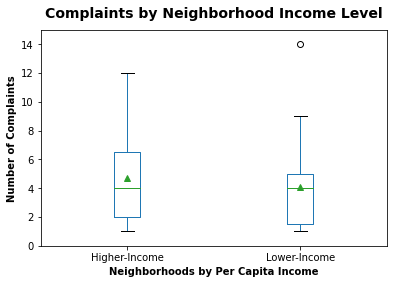

In [13]:
# Group neighborhoods in Chicago into lower-income vs higher-income
lower_income_df = air_pollution_df.loc[air_pollution_df["PER CAPITA INCOME "] < avg_chicago_income]
higher_income_df = air_pollution_df.loc[air_pollution_df["PER CAPITA INCOME "] > avg_chicago_income]

# Create dataframe showing number of complaints by lower-income neighborhood in descending order 
lower_income_neighborhood = lower_income_df.groupby(["Neighborhood"])
lower_complaint_count = lower_income_neighborhood["COMPLAINT ID"].count()
lower_income_neighborhood_df = pd.DataFrame({"Number of Complaints": lower_complaint_count})
lower_income_neighborhood_df = lower_income_neighborhood_df.sort_values(["Number of Complaints"], ascending = False).reset_index()
lower_income_neighborhood_df["Neighborhood Income"] = "Lower-Income"

# Create dataframe showing number of complaints by higher-income neighborhood in descending order 
higher_income_neighborhood = higher_income_df.groupby(["Neighborhood"])
higher_complaint_count = higher_income_neighborhood["COMPLAINT ID"].count()
higher_income_neighborhood_df = pd.DataFrame({"Number of Complaints": higher_complaint_count})
higher_income_neighborhood_df = higher_income_neighborhood_df.sort_values(["Number of Complaints"], ascending = False).reset_index()
higher_income_neighborhood_df["Neighborhood Income"] = "Higher-Income"

neighborhoods = [lower_income_neighborhood_df, higher_income_neighborhood_df]
all_neighborhoods_df = pd.concat(neighborhoods)
all_neighborhoods_df.boxplot(by = "Neighborhood Income", showmeans = True)
plt.title("")
plt.grid(False)
plt.ylim(0, 15)
plt.suptitle("Complaints by Neighborhood Income Level", fontsize = 14, fontweight = "bold")
plt.xlabel("Neighborhoods by Per Capita Income", fontsize = 10, fontweight = "bold")
plt.ylabel("Number of Complaints", fontsize = 10, fontweight = "bold")
plt.savefig("Output/Q2_Boxplot.png")
plt.show()

### Scatter Plot of Complaints by Income Level

In [14]:
# import merged dataset
path = "Resources/merged_data.csv"
pollution_df = pd.read_csv(path)
# group by neighborhood and find the frequency of complaints per neighborhood
grouped_df = pollution_df.groupby(by="Neighborhood")
# finds the number of complaints and avg income per neighborhood
grouped_complaint = pd.DataFrame()
grouped_complaint["Complaint frequency"] = grouped_df["COMPLAINT TYPE"].count()
grouped_complaint["Avg Per Capita Income"] = grouped_df["PER CAPITA INCOME "].mean()
grouped_complaint.head()

,Complaint frequency,Avg Per Capita Income
Neighborhood,,
Albany Park,4,21323.0
Archer Heights,1,16134.0
Ashburn,4,23482.0
Auburn Gresham,4,15528.0
Austin,4,15957.0


The r-squared is: 0.00788519238548034


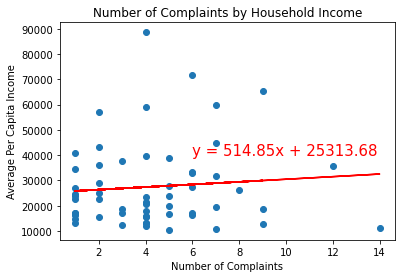

In [15]:
# scatter plot Y - income  X - frequency of complaint; linear regression
# set up x and y values
x_values = grouped_complaint['Complaint frequency']
y_values = grouped_complaint['Avg Per Capita Income']
# create linear regression line
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
# plot scatter plot with lin regress line
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
# formatting
plt.annotate(line_eq,(6,40000),fontsize=15,color="red")
plt.ylabel('Average Per Capita Income')
plt.xlabel('Number of Complaints')
plt.title("Number of Complaints by Household Income")
print(f"The r-squared is: {rvalue**2}")
plt.savefig("Output/Q2_ScatterPlot.png")
plt.show()

## **Question 3: Did the number of air pollution complaints vary by the presence of minority communities?**
-----

### Stacked Bar Chart of Racial Breakdown by Neighborhood

In [16]:
# Merged Data
m_data_path = "https://raw.githubusercontent.com/nhakkarainen/NU-Project-1/main/Resources/merged_data.csv" 
m_data = pd.read_csv(m_data_path)
m_data.head()

,Unnamed: 0,COMPLAINT ID,COMPLAINT TYPE,ADDRESS,Neighborhood,STREET NUMBER FROM,STREET NUMBER TO,DIRECTION,STREET NAME,STREET TYPE,...,LONGITUDE,LOCATION,Community Area Number,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,0,DOECOMP29999,Air Pollution Work Order,"700 E 107TH ST, CHICAGO, IL",Pullman,700,NaN,E,107TH,ST,...,NaN,NaN,50.0,1.5,21.6,22.8,13.1,38.6,20588,51.0
1,1,DOECOMP29998,Air Pollution Work Order,"700 E 107TH ST, CHICAGO, IL",Pullman,700,NaN,E,107TH,ST,...,NaN,NaN,50.0,1.5,21.6,22.8,13.1,38.6,20588,51.0
2,2,DOECOMP30000,Air Pollution Work Order,"700 E 107TH ST, CHICAGO, IL",Pullman,700,NaN,E,107TH,ST,...,NaN,NaN,50.0,1.5,21.6,22.8,13.1,38.6,20588,51.0
3,3,DOECOMP1839,Air Pollution Work Order,"11436 S FORRESTVILLE AVE, CHICAGO, IL",Pullman,11436,NaN,S,FORRESTVILLE,AVE,...,NaN,NaN,50.0,1.5,21.6,22.8,13.1,38.6,20588,51.0
4,4,DOECOMP8772,Air Pollution Work Order,"2019 W 111TH ST, CHICAGO, IL",Morgan Park,2019,NaN,W,111TH,ST,...,NaN,NaN,75.0,0.8,13.2,15.0,10.8,40.3,27149,30.0


In [17]:
# CMAP Data
cmap_data_path = "https://raw.githubusercontent.com/nhakkarainen/NU-Project-1/main/Resources/2010%20CMAP%20Data.csv"
cmap_data = pd.read_csv(cmap_data_path)
cmap_data = cmap_data.dropna(axis = 'columns')
cmap_data

,Geog,GeogKey,Total Population,"Not Hispanic or Latino, White alone","Not Hispanic or Latino, Black or African American alone","Not Hispanic or Latino, American Indian and Alaska Native alone","Not Hispanic or Latino, Asian alone","Not Hispanic or Latino, Native Hawaiian and Other Pacific Islander alone","Not Hispanic or Latino, Some Other Race alone","Not Hispanic or Latino, Two or More Races",...,Median Age,Total Households,Average Household Size,Total Housing Units,Occupied Housing Units,Vacant Housing Units,Occupied Housing Units.1,Owned with a mortgage or a loan,Owned free and clear,Renter occupied
0,Rogers Park,1,54991,21618,14461,142,3523,39,202,1573,...,32.4,24292,2.13,27564,24292,3272,24292,6128,1009,17155
1,West Ridge,2,71942,30706,8015,189,16184,3,225,1919,...,35.1,24755,2.85,27466,24755,2711,24755,8829,3367,12559
2,Uptown,3,56362,29098,11275,191,6414,10,130,1235,...,35.5,29719,1.79,32541,29719,2822,29719,8298,1230,20191
3,Lincoln Square,4,39493,24916,1488,72,4399,11,128,917,...,33.5,18194,2.14,19906,18194,1712,18194,5482,1406,11306
4,North Center,5,31867,24634,738,55,1449,16,51,594,...,32.5,14561,2.18,16197,14561,1636,14561,5805,1147,7609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Washington Heights,73,26493,121,25793,36,12,4,18,251,...,41.2,9482,2.77,10365,9482,883,9482,4626,1921,2935
73,Mount Greenwood,74,19093,16413,987,34,126,3,6,142,...,36.1,6990,2.63,7374,6990,384,6990,4440,1555,995
74,Morgan Park,75,22544,6473,15039,11,92,8,24,278,...,40.5,8187,2.70,8958,8187,771,8187,4400,1534,2253
75,O'Hare,76,12756,9845,403,15,1058,2,24,197,...,36.6,6127,2.08,6677,6127,550,6127,1843,881,3403


In [18]:
# Renaming CMAP columns
cmap_data = cmap_data.rename(columns= {'Geog' : 'Neighborhood', 
                                       'Not Hispanic or Latino, White alone' : 'White', 
                                       'Not Hispanic or Latino, Black or African American alone' : 'Black or African American',
                                       'Not Hispanic or Latino, American Indian and Alaska Native alone' : 'American Indian and Alaska Native',
                                       'Not Hispanic or Latino, Asian alone' : 'Asian',
                                       'Not Hispanic or Latino, Native Hawaiian and Other Pacific Islander alone' : 'Native Hawaiian and Other Pacific Islander',
                                       'Not Hispanic or Latino, Some Other Race alone' : 'Other',
                                       'Not Hispanic or Latino, Two or More Races' : 'Two or more Races'})

In [19]:
cmap_data['Minority Percentage'] = (cmap_data['White'] / cmap_data['Total Population'])
cmap_data['Minority Percentage'] = pd.Series(['{0:.2f}%'.format((1-val) * 100) for val in cmap_data['Minority Percentage'] ],
                                                           index = cmap_data.index)
cmap_data

,Neighborhood,GeogKey,Total Population,White,Black or African American,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Other,Two or more Races,...,Total Households,Average Household Size,Total Housing Units,Occupied Housing Units,Vacant Housing Units,Occupied Housing Units.1,Owned with a mortgage or a loan,Owned free and clear,Renter occupied,Minority Percentage
0,Rogers Park,1,54991,21618,14461,142,3523,39,202,1573,...,24292,2.13,27564,24292,3272,24292,6128,1009,17155,60.69%
1,West Ridge,2,71942,30706,8015,189,16184,3,225,1919,...,24755,2.85,27466,24755,2711,24755,8829,3367,12559,57.32%
2,Uptown,3,56362,29098,11275,191,6414,10,130,1235,...,29719,1.79,32541,29719,2822,29719,8298,1230,20191,48.37%
3,Lincoln Square,4,39493,24916,1488,72,4399,11,128,917,...,18194,2.14,19906,18194,1712,18194,5482,1406,11306,36.91%
4,North Center,5,31867,24634,738,55,1449,16,51,594,...,14561,2.18,16197,14561,1636,14561,5805,1147,7609,22.70%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Washington Heights,73,26493,121,25793,36,12,4,18,251,...,9482,2.77,10365,9482,883,9482,4626,1921,2935,99.54%
73,Mount Greenwood,74,19093,16413,987,34,126,3,6,142,...,6990,2.63,7374,6990,384,6990,4440,1555,995,14.04%
74,Morgan Park,75,22544,6473,15039,11,92,8,24,278,...,8187,2.70,8958,8187,771,8187,4400,1534,2253,71.29%
75,O'Hare,76,12756,9845,403,15,1058,2,24,197,...,6127,2.08,6677,6127,550,6127,1843,881,3403,22.82%


In [20]:
race_data = cmap_data.iloc[:, [0, 3,4,5,6,7,8,9,10,67]]
race_data.sort_values('Neighborhood')

,Neighborhood,White,Black or African American,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Other,Two or more Races,Hispanic or Latino,Minority Percentage
13,Albany Park,15054,2076,119,7430,22,159,1195,25487,70.79%
56,Archer Heights,2874,130,15,138,0,11,43,10182,78.54%
33,Armour Square,1642,1419,4,9721,1,2,138,464,87.74%
69,Ashburn,6251,18976,45,276,1,26,374,15132,84.78%
70,Auburn Gresham,134,47661,81,33,2,24,349,459,99.73%
...,...,...,...,...,...,...,...,...,...,...
64,West Lawn,4924,1390,28,210,3,18,113,26669,85.24%
52,West Pullman,166,27593,45,14,2,13,309,1509,99.44%
1,West Ridge,30706,8015,189,16184,3,225,1919,14701,57.32%
23,West Town,47051,6404,121,3106,28,160,1465,23901,42.79%


In [21]:
# Combining Data Sets
demo_data = pd.merge(m_data, race_data, on = 'Neighborhood')
demo_data

,Unnamed: 0,COMPLAINT ID,COMPLAINT TYPE,ADDRESS,Neighborhood,STREET NUMBER FROM,STREET NUMBER TO,DIRECTION,STREET NAME,STREET TYPE,...,HARDSHIP INDEX,White,Black or African American,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Other,Two or more Races,Hispanic or Latino,Minority Percentage
0,0,DOECOMP29999,Air Pollution Work Order,"700 E 107TH ST, CHICAGO, IL",Pullman,700,NaN,E,107TH,ST,...,51.0,522,6122,8,5,0,8,89,571,92.87%
1,1,DOECOMP29998,Air Pollution Work Order,"700 E 107TH ST, CHICAGO, IL",Pullman,700,NaN,E,107TH,ST,...,51.0,522,6122,8,5,0,8,89,571,92.87%
2,2,DOECOMP30000,Air Pollution Work Order,"700 E 107TH ST, CHICAGO, IL",Pullman,700,NaN,E,107TH,ST,...,51.0,522,6122,8,5,0,8,89,571,92.87%
3,3,DOECOMP1839,Air Pollution Work Order,"11436 S FORRESTVILLE AVE, CHICAGO, IL",Pullman,11436,NaN,S,FORRESTVILLE,AVE,...,51.0,522,6122,8,5,0,8,89,571,92.87%
4,4,DOECOMP8772,Air Pollution Work Order,"2019 W 111TH ST, CHICAGO, IL",Morgan Park,2019,NaN,W,111TH,ST,...,30.0,6473,15039,11,92,8,24,278,619,71.29%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,243,DOECOMP31879,Air Pollution Work Order,"7600 S SEELEY AVE, CHICAGO, IL",Auburn Gresham,7600,NaN,S,SEELEY,AVE,...,74.0,134,47661,81,33,2,24,349,459,99.73%
235,244,DOECOMP32306,Air Pollution Work Order,"7901 S WENTWORTH AVE, CHICAGO, IL",Auburn Gresham,7901,NaN,S,WENTWORTH,AVE,...,74.0,134,47661,81,33,2,24,349,459,99.73%
236,245,DOECOMP32307,Air Pollution Work Order,"7901 S WENTWORTH AVE, CHICAGO, IL",Auburn Gresham,7901,NaN,S,WENTWORTH,AVE,...,74.0,134,47661,81,33,2,24,349,459,99.73%
237,246,DOECOMP35677,Air Pollution Work Order,"13000 S TORRENCE AVE, CHICAGO, IL",South Deering,13000,NaN,S,TORRENCE,AVE,...,65.0,725,9354,31,18,1,15,156,4809,95.20%


In [22]:
neighborhood_df = demo_data['Neighborhood']
neighborhood_df = neighborhood_df.drop_duplicates()

In [23]:
hood_data = demo_data.groupby(by= 'Neighborhood')
count_df = hood_data.count()
count_df

,Unnamed: 0,COMPLAINT ID,COMPLAINT TYPE,ADDRESS,STREET NUMBER FROM,STREET NUMBER TO,DIRECTION,STREET NAME,STREET TYPE,INSPECTOR,...,HARDSHIP INDEX,White,Black or African American,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Other,Two or more Races,Hispanic or Latino,Minority Percentage
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Albany Park,4,4,4,4,4,0,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
Archer Heights,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Ashburn,4,4,4,4,4,0,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
Auburn Gresham,4,4,4,4,4,0,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
Austin,4,4,4,4,4,0,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
Avalon Park,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Avondale,5,5,5,5,5,0,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
Belmont Cragin,2,2,2,2,2,1,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Beverly,4,4,4,4,4,0,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


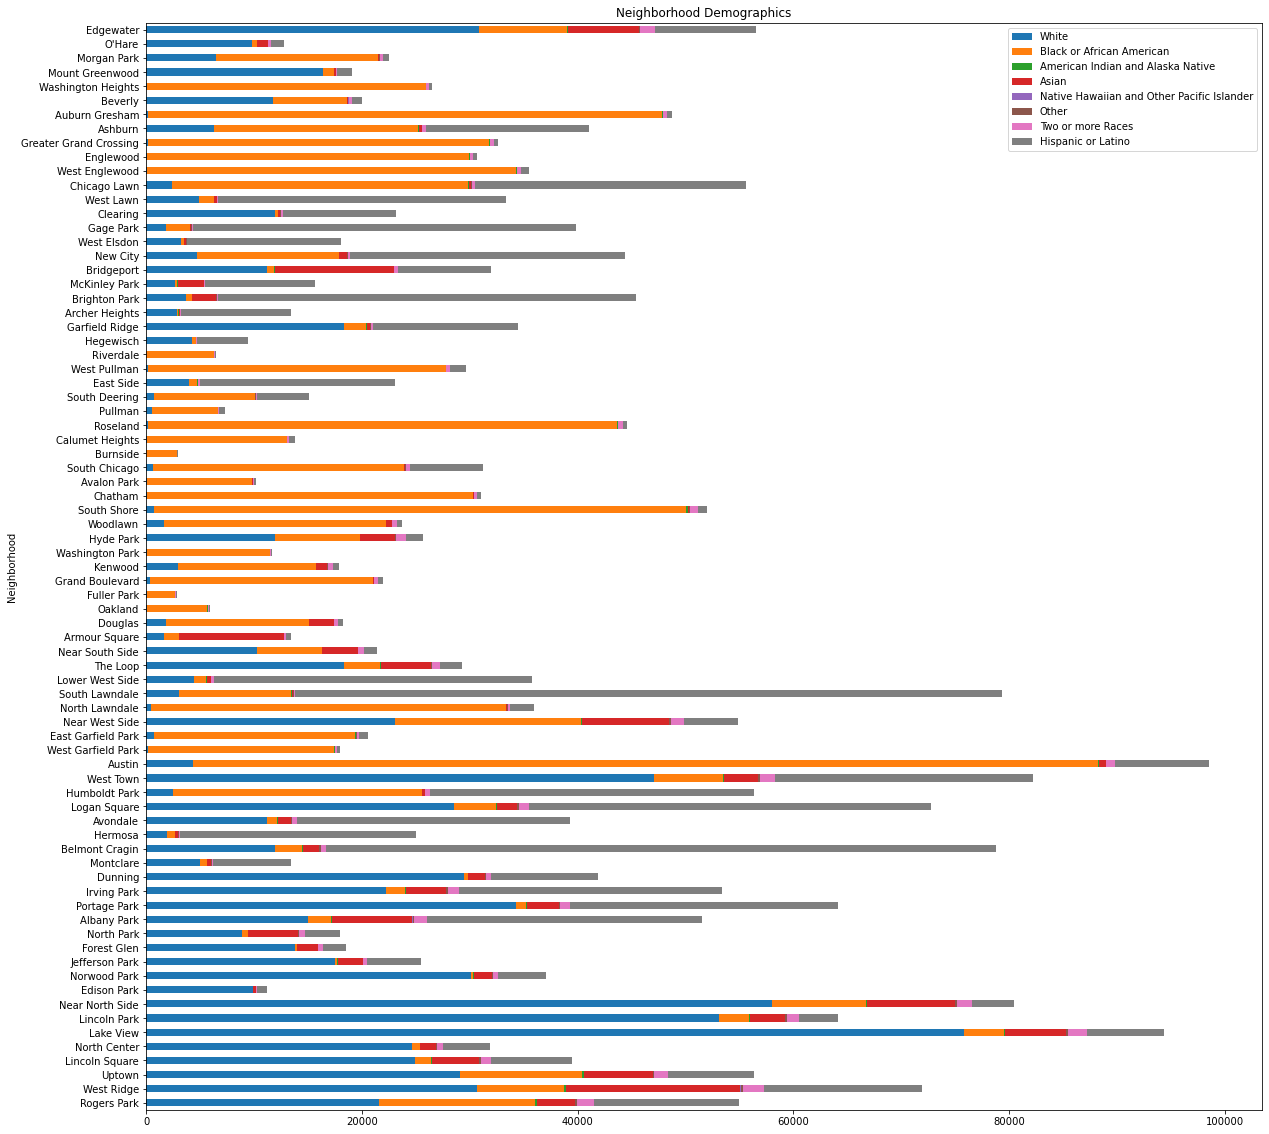

In [24]:
# Neighborhood Demographic breakdown
ax = race_data.plot.barh(x="Neighborhood", stacked = True, figsize = (20,20), xlabel = 'Neighborhood', title = 'Neighborhood Demographics')
plt.savefig("Output/Q3_StackedBarChart.png")
plt.show()

### Scatter Plot of Complaints by % Minority Population

In [25]:
complaint_df = count_df['COMPLAINT ID']
complaint_df

Neighborhood
Albany Park                4
Archer Heights             1
Ashburn                    4
Auburn Gresham             4
Austin                     4
Avalon Park                1
Avondale                   5
Belmont Cragin             2
Beverly                    4
Bridgeport                 1
Brighton Park              4
Calumet Heights            2
Chatham                    9
Chicago Lawn               1
Clearing                   2
Douglas                    5
Dunning                    8
East Garfield Park         4
East Side                  1
Edgewater                  6
Edison Park                1
Englewood                  4
Gage Park                  3
Greater Grand Crossing     6
Hegewisch                  2
Hyde Park                  5
Irving Park                6
Jefferson Park             5
Kenwood                    2
Lake View                  7
Lincoln Park               6
Lincoln Square             3
Logan Square               7
Lower West Side            6
M

In [26]:
chart_data = pd.merge(complaint_df, race_data, on = 'Neighborhood')
chart_data = chart_data.iloc[: , [0,1,10]]
chart_data

,Neighborhood,COMPLAINT ID,Minority Percentage
0,Albany Park,4,70.79%
1,Archer Heights,1,78.54%
2,Ashburn,4,84.78%
3,Auburn Gresham,4,99.73%
4,Austin,4,95.57%
5,Avalon Park,1,99.20%
6,Avondale,5,71.56%
7,Belmont Cragin,2,84.81%
8,Beverly,4,41.18%
9,Bridgeport,1,64.90%


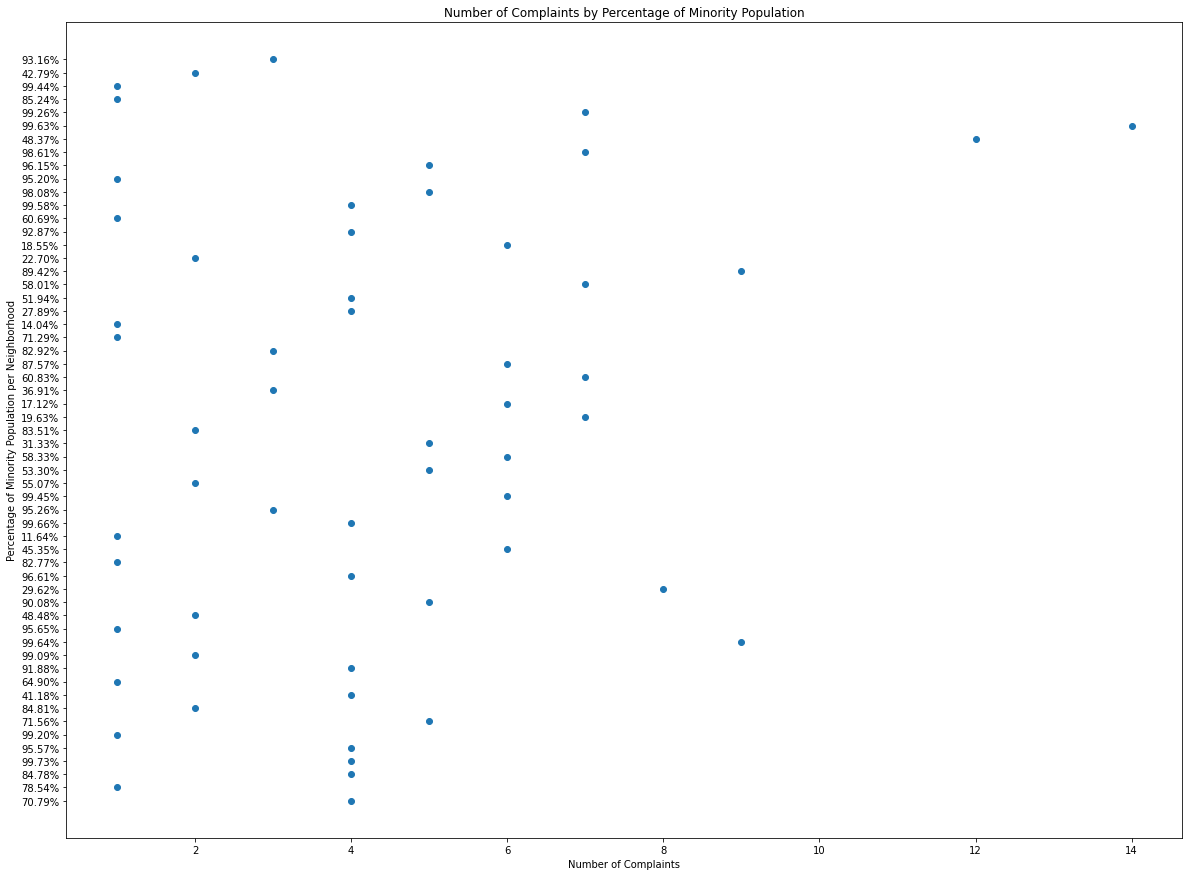

In [27]:
# Scatterplot Y-Minority %, x-Complaint Frequency
# Set up x and y values
x_values = chart_data['COMPLAINT ID']
y_values = chart_data['Minority Percentage']
# plot scatterplot
plt.figure(figsize = (20,15))
figure = plt.scatter(x_values,y_values)
#Formating
plt.ylabel('Percentage of Minority Population per Neighborhood')
plt.xlabel('Number of Complaints')
plt.title('Number of Complaints by Percentage of Minority Population')
plt.savefig("Output/Q3_ScatterPlot.png")
plt.show()